# Individual Plot

In [7]:
import torch

n = 100
d = 5
dl = 20

X = torch.randn((n,d))
Y = torch.randn((n,1))

X_test = torch.randn((n,d))

class oneLayerMLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.output_size = 1
        self.linear1 = torch.nn.Linear(d,dl,bias=False)
        self.linear2 = torch.nn.Linear(dl,1,bias=False)
        self.act = torch.nn.Tanh()

    def forward(self, x):
        x = self.act(self.linear1(x)) /  (dl**0.5)
        x = self.linear2(x)
        return x

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        # torch.nn.init.kaiming_normal(m.weight, mode='fan_out', nonlinearity='relu')
        torch.nn.init.normal_(m.weight,mean=0,std=1)

net = oneLayerMLP()
net.apply(weights_init)


oneLayerMLP(
  (linear1): Linear(in_features=5, out_features=20, bias=False)
  (linear2): Linear(in_features=20, out_features=1, bias=False)
  (act): Tanh()
)

In [9]:
optimizer = torch.optim.SGD(net.parameters(),lr=0.1,momentum=0.9)
loss_fn = torch.nn.MSELoss()
for i in range(1000):
    optimizer.zero_grad()
    pred = net(X)
    loss = loss_fn(pred,Y)
    loss.backward()
    optimizer.step()
    print(f'loss = {loss.item():.4}')

loss = 0.6789
loss = 0.6786
loss = 0.678
loss = 0.6772
loss = 0.6761
loss = 0.6749
loss = 0.6735
loss = 0.672
loss = 0.6703
loss = 0.6685
loss = 0.6666
loss = 0.6645
loss = 0.6624
loss = 0.6602
loss = 0.658
loss = 0.6557
loss = 0.6533
loss = 0.651
loss = 0.6485
loss = 0.6461
loss = 0.6436
loss = 0.6411
loss = 0.6386
loss = 0.6361
loss = 0.6336
loss = 0.6311
loss = 0.6286
loss = 0.6261
loss = 0.6236
loss = 0.6211
loss = 0.6186
loss = 0.6161
loss = 0.6136
loss = 0.6112
loss = 0.6088
loss = 0.6063
loss = 0.6039
loss = 0.6016
loss = 0.5992
loss = 0.5968
loss = 0.5945
loss = 0.5922
loss = 0.5899
loss = 0.5876
loss = 0.5853
loss = 0.5831
loss = 0.5809
loss = 0.5787
loss = 0.5765
loss = 0.5743
loss = 0.5722
loss = 0.57
loss = 0.5679
loss = 0.5659
loss = 0.5638
loss = 0.5617
loss = 0.5597
loss = 0.5577
loss = 0.5557
loss = 0.5537
loss = 0.5518
loss = 0.5498
loss = 0.5479
loss = 0.546
loss = 0.5441
loss = 0.5422
loss = 0.5404
loss = 0.5385
loss = 0.5367
loss = 0.5349
loss = 0.5331
loss = 0.5313

In [10]:
# Compute NTKGP
from functorch import make_functional
from torch.func import functional_call, vmap, jacrev, jvp

fnet, params = make_functional(net)
## Compute jacobian of net, evaluated on training set
def fnet_single(params, x):
    return fnet(params, x.unsqueeze(0)).squeeze(0)

def Jx(Xs):
    J = vmap(jacrev(fnet_single), (None, 0))(params, Xs)
    J = [j.detach().flatten(1) for j in J]
    J = torch.cat(J,dim=1).detach()
    return J

lam = 0
Jtrain = Jx(X)
NTK_X = Jtrain @ Jtrain.T + lam*torch.eye(n)

print(torch.linalg.cond(NTK_X))

var_pred = []
for xi in X_test:
    Jsingle = Jx(xi.unsqueeze(0))
    KXx = Jtrain @ Jsingle.T
    var = Jsingle @ Jsingle.T - KXx.T @ torch.linalg.solve(NTK_X,KXx)
    var_pred.append(var)
var_pred = torch.tensor(var_pred)

tensor(41199.2391)


C:\Users\s4531973\AppData\Local\Temp\ipykernel_14068\3858721378.py:5: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(net)


In [11]:
var_pred

tensor([0.0374, 0.0108, 0.0498, 0.1041, 0.0478, 0.0586, 0.0947, 0.2524, 0.0492,
        0.6637, 0.0315, 0.0269, 0.0706, 0.1513, 0.1719, 0.0513, 0.7495, 0.1265,
        0.0301, 0.1154, 0.0138, 0.2414, 0.0446, 0.0332, 0.0474, 0.1816, 0.2150,
        0.3410, 0.2578, 0.1924, 0.0536, 0.0098, 0.0588, 0.0493, 0.0164, 0.4271,
        0.3089, 0.0573, 0.0271, 0.0704, 0.0957, 0.0879, 0.0814, 0.0113, 0.0200,
        0.1150, 0.2112, 0.0632, 0.0188, 0.0544, 0.0386, 0.1076, 0.0349, 0.2741,
        0.1807, 0.0905, 0.0167, 0.1054, 0.1066, 0.1341, 0.2252, 0.1418, 0.1667,
        0.1804, 0.3647, 0.0800, 0.0521, 0.0368, 0.3062, 0.1066, 0.1570, 0.1664,
        0.0545, 0.0337, 0.0503, 0.2141, 0.2720, 0.0100, 0.1206, 0.2006, 0.0686,
        0.0577, 0.1098, 0.0460, 0.0271, 0.1812, 0.7158, 0.0218, 0.2820, 0.1614,
        0.1381, 0.0141, 0.0561, 0.3522, 0.0355, 0.0210, 0.2823, 0.3173, 0.0859,
        0.1560])

In [15]:
## NUQLS
import posteriors.nuqls as nuqls
from importlib import reload
reload(nuqls)
from torch.utils.data import DataLoader, Dataset

class toy_dataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
train_data = toy_dataset(X,Y)
test_data = toy_dataset(X_test,Y)

# nuql_test_preds = nuqls.regression_parallel(net, train=train_data, test=test_data, ood_test=None, train_bs = n, test_bs =n, 
#                                                 S = 1000, scale=1, lr=8, epochs=10000, mu=0.9, verbose=True)
# nuql_mu2 = nuql_test_preds.mean(1)
# nuql_var2 = nuql_test_preds.var(1)

# print(nuql_var2)
# print(f's: {s}, convergence = {torch.linalg.norm(nuql_var2 - var_pred)}')

diff = []
losses = []

epochs = torch.logspace(1,4,10)
for epoch in epochs:
    nuql_test_preds, loss = nuqls.regression_parallel(net, train=train_data, test=test_data, ood_test=None, train_bs = n, test_bs =n, 
                                                S = 1000, scale=1, lr=1, epochs=int(epoch.item()), mu=0.9)
    nuql_mu2 = nuql_test_preds.mean(1)
    nuql_var2 = nuql_test_preds.var(1)

    print(f'epoch: {epoch}, convergence = {torch.linalg.norm(nuql_var2 - var_pred):.4}, loss = {loss:.4}')
    diff.append(torch.linalg.norm(nuql_var2 - var_pred).item())
    losses.append(loss)

# s_range = torch.linspace(10,1000,10)
# for s in s_range:
#     nuql_test_preds = nuqls.regression_parallel(net, train=train_data, test=test_data, ood_test=None, train_bs = n, test_bs =n, 
#                                                 S = int(s.item()), scale=1, lr=8, epochs=4000, mu=0.9)
#     nuql_mu2 = nuql_test_preds.mean(1)
#     nuql_var2 = nuql_test_preds.var(1)

#     print(f's: {s}, convergence = {torch.linalg.norm(nuql_var2 - var_pred)}')
#     diff.append(torch.linalg.norm(nuql_var2 - var_pred).item())
#     losses.append(loss)

c:\Users\s4531973\Documents\PhD\Code\nuqls_paper\posteriors\nuqls.py:356: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(net)
100%|██████████| 10/10 [00:00<00:00, 98.78it/s]


epoch: 10.0, convergence = 30.4, loss = 1.756


100%|██████████| 21/21 [00:00<00:00, 97.59it/s]


epoch: 21.544346900318832, convergence = 12.59, loss = 0.6119


100%|██████████| 46/46 [00:00<00:00, 94.53it/s]


epoch: 46.41588833612777, convergence = 4.272, loss = 0.07386


100%|██████████| 100/100 [00:01<00:00, 95.99it/s]


epoch: 100.0, convergence = 2.142, loss = 0.03248


100%|██████████| 215/215 [00:02<00:00, 93.28it/s]


epoch: 215.44346900318823, convergence = 1.204, loss = 0.02111


100%|██████████| 464/464 [00:05<00:00, 92.25it/s]


epoch: 464.1588833612782, convergence = 0.6878, loss = 0.01332


100%|██████████| 1000/1000 [00:10<00:00, 92.43it/s]


epoch: 1000.0, convergence = 0.2786, loss = 0.007301


100%|██████████| 2154/2154 [00:39<00:00, 55.05it/s]


epoch: 2154.4346900318847, convergence = 0.1095, loss = 0.002746


 14%|█▍        | 648/4641 [00:12<01:17, 51.44it/s]


KeyboardInterrupt: 

In [13]:
nuql_var2

tensor([1.2494e+304, 9.0615e+303, 7.2890e+302, 8.1017e+303, 3.1570e+304,
        4.2975e+303, 9.9589e+303, 1.8077e+303, 1.5097e+303, 2.1021e+303,
        3.1763e+300, 6.0914e+303, 1.3898e+303, 2.1718e+304, 1.4342e+303,
        1.4515e+303, 1.7039e+304, 9.8129e+302, 1.7375e+304, 3.4715e+302,
        1.4201e+303, 6.3189e+302, 2.9923e+303, 4.0060e+301, 1.1669e+303,
        1.8514e+303, 1.2462e+303, 1.1149e+304, 3.0095e+300, 5.8685e+300,
        7.3081e+303, 5.9411e+303, 5.5187e+301, 4.6369e+303, 1.3749e+303,
        4.9305e+303, 5.1374e+303, 4.3200e+302, 2.6879e+303, 8.0445e+302,
        8.7554e+299, 5.8691e+303, 9.2411e+302, 8.7592e+302, 1.2717e+304,
        2.9999e+303, 1.0473e+304, 1.2845e+304, 1.1563e+303, 1.4842e+304,
        3.3133e+304, 5.1003e+302, 4.8569e+303, 7.7009e+302, 6.2338e+301,
        3.8553e+303, 1.5555e+303, 9.2221e+302, 5.9680e+303, 7.3711e+301,
        2.1559e+303, 1.0653e+304, 1.2411e+299, 1.9043e+304, 4.8844e+304,
        4.6450e+301, 5.1664e+302, 3.7718e+303, 1.95

In [437]:
diff = []
losses = []

s_range = torch.logspace(1,4,10)
for s in s_range:
    nuql = nuqls.small_regression_parallel(net, train=train_data, S = int(s.item()),epochs=10000,lr=8,bs=n,bs_test=n,init_scale=1)
    loss,resid = nuql.train_linear(mu=0.9,weight_decay=0,my=0,sy=1,threshold=None,verbose=False, progress_bar=True)


    nuql_test_preds = nuql.test_linear(test=test_data)
    
    nuql_mu2 = nuql_test_preds.mean(1)
    nuql_var2 = nuql_test_preds.var(1)

    print(f's: {s}, convergence = {torch.linalg.norm(nuql_var2 - var_pred)}')
    diff.append(torch.linalg.norm(nuql_var2 - var_pred).item())
    losses.append(loss)

C:\Users\s4531973\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_functorch\deprecated.py:97: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
100%|██████████| 10000/10000 [00:03<00:00, 3111.35it/s]


s: 10.0, convergence = 0.07651065542649285


100%|██████████| 10000/10000 [00:03<00:00, 2827.61it/s]


s: 21.544346900318832, convergence = 0.09863359954997465


100%|██████████| 10000/10000 [00:03<00:00, 2625.45it/s]


s: 46.41588833612777, convergence = 0.0651765797230987


100%|██████████| 10000/10000 [00:04<00:00, 2272.77it/s]


s: 100.0, convergence = 0.0193723928261297


100%|██████████| 10000/10000 [00:05<00:00, 1747.16it/s]


s: 215.44346900318823, convergence = 0.027560130670083012


100%|██████████| 10000/10000 [00:11<00:00, 840.85it/s]


s: 464.1588833612782, convergence = 0.009553299180201417


100%|██████████| 10000/10000 [00:14<00:00, 670.72it/s]


s: 1000.0, convergence = 0.008154594044864258


100%|██████████| 10000/10000 [00:22<00:00, 436.70it/s]


s: 2154.4346900318847, convergence = 0.008854252405313737


100%|██████████| 10000/10000 [00:43<00:00, 227.95it/s]


s: 4641.588833612777, convergence = 0.005717789970613724


100%|██████████| 10000/10000 [03:52<00:00, 43.03it/s]

s: 10000.0, convergence = 0.007097708416363211


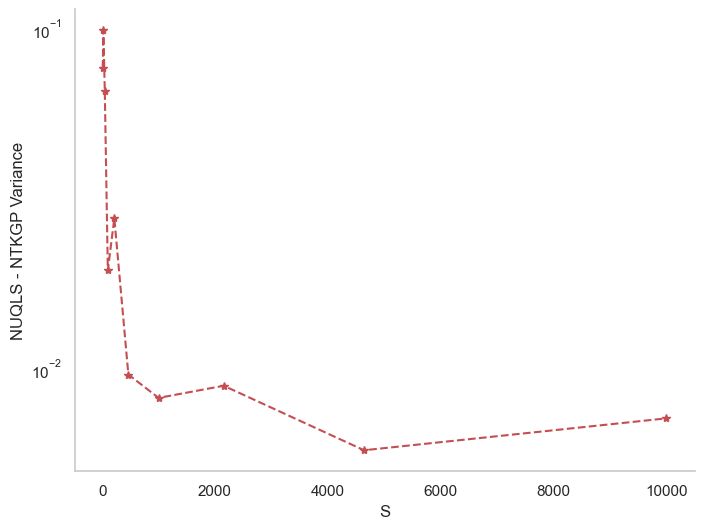

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(figsize=(8,6),frameon=True,)

ax1.plot(s_range,diff,'r--*',label='Variance Squared Error')
ax1.set_ylabel('NUQLS - NTKGP Variance')
ax1.set_yscale('log')
ax1.set_xlabel('S')

plt.savefig(fname='S_ntk_convergence.pdf', format='pdf')

In [411]:
for i,d in enumerate(diff):
    diff[i] = d.item()

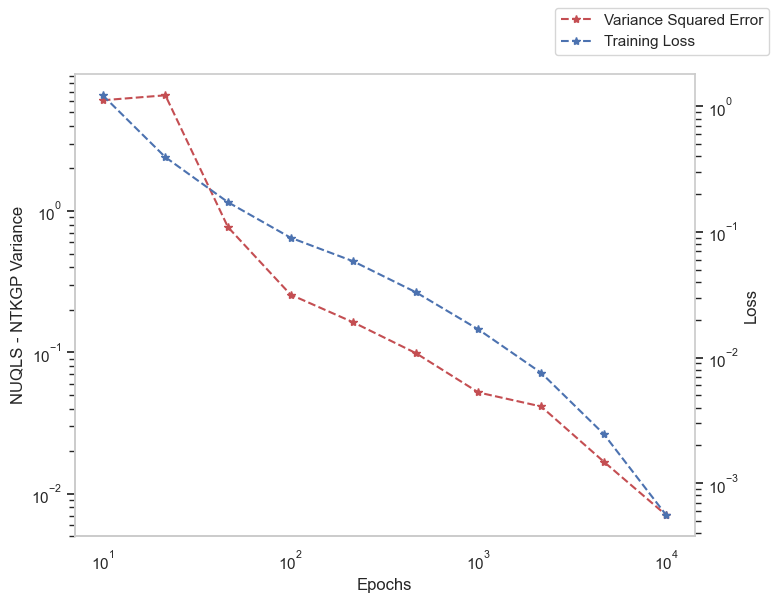

In [442]:
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(figsize=(8,6),frameon=True,)

ax2 = ax1.twinx()

ax1.plot(epochs,diff,'r--*',label='Variance Squared Error')
ax1.set_ylabel('NUQLS - NTKGP Variance')
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax2.plot(epochs,losses,'b--*',label='Training Loss')
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)
ax2.set_ylabel('Loss')
ax2.set_yscale('log')
ax2.set_xscale('log')

fig.legend()

plt.savefig(fname='epochs_ntk_convergence.pdf', format='pdf')

# Statistical Plot

In [ ]:
import torch
from functorch import make_functional
from torch.func import functional_call, vmap, jacrev, jvp
    ## NUQLS
import posteriors.nuqls as nuqls
from importlib import reload
reload(nuqls)
from torch.utils.data import DataLoader, Dataset
import tqdm

n = 100
d = 5
dl = 20

class toy_dataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
class oneLayerMLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.output_size = 1
        self.linear1 = torch.nn.Linear(d,dl,bias=False)
        self.linear2 = torch.nn.Linear(dl,dl,bias=False)
        self.linear3 = torch.nn.Linear(dl,1,bias=False)
        self.act = torch.nn.ReLU()

    def forward(self, x):
        x = self.act(self.linear1(x)) /  (dl**0.5)
        x = self.act(self.linear2(x)) /  (dl**0.5)
        x = self.linear3(x)
        return x

def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        # torch.nn.init.kaiming_normal(m.weight, mode='fan_out', nonlinearity='relu')
            torch.nn.init.normal_(m.weight,mean=0,std=1)

def convergence(n,d,lr=1,verbose=False):
    X = torch.randn((n,d))
    Y = torch.randn((n,1))

    X_test = torch.randn((n,d))

    net = oneLayerMLP()
    net.apply(weights_init)

    optimizer = torch.optim.SGD(net.parameters(),lr=0.1,momentum=0.9)
    loss_fn = torch.nn.MSELoss()
    for i in range(5000):
        optimizer.zero_grad()
        pred = net(X)
        loss = loss_fn(pred,Y)
        loss.backward()
        optimizer.step()

    if verbose:
        print(f'nn loss : {loss.item():.4}')

    # Compute NTKGP
    fnet, params = make_functional(net)

    ## Compute jacobian of net, evaluated on training set
    def fnet_single(params, x):
        return fnet(params, x.unsqueeze(0)).squeeze(0)

    def Jx(Xs):
        J = vmap(jacrev(fnet_single), (None, 0))(params, Xs)
        J = [j.detach().flatten(1) for j in J]
        J = torch.cat(J,dim=1).detach()
        return J

    lam = 0
    Jtrain = Jx(X)
    NTK_X = Jtrain @ Jtrain.T + lam*torch.eye(n)

    print(f'Cond(J J^T) = {torch.linalg.cond(NTK_X).item():.1}')

    var_ntk = []
    for xi in X_test:
        Jsingle = Jx(xi.unsqueeze(0))
        KXx = Jtrain @ Jsingle.T
        var = Jsingle @ Jsingle.T - KXx.T @ torch.linalg.solve(NTK_X,KXx)
        var_ntk.append(var)
    var_ntk = torch.tensor(var_ntk)
    
    train_data = toy_dataset(X,Y)
    test_data = toy_dataset(X_test,Y)

    diff_e = []
    losses_e = []

    epochs = torch.logspace(1,4,10)
    for epoch in tqdm.tqdm(epochs):
        # nuql_test_preds, loss = nuqls.regression_parallel(net, train=train_data, test=test_data, ood_test=None, train_bs = n, test_bs =n, 
        #                                             S = 1000, scale=1, lr=8, epochs=int(epoch.item()), mu=0.9)
        
        nuql = nuqls.small_regression_parallel(net, train=train_data, S = 1000, epochs=int(epoch.item()), lr=lr, bs=n, bs_test=n, init_scale=1)
        loss,_ = nuql.train_linear(mu=0.9,weight_decay=0,my=0,sy=1,threshold=None,verbose=False, progress_bar=False)
        nuql_test_preds = nuql.test_linear(test=test_data)
        
        var_nuqls = nuql_test_preds.var(1)

        # print(f'epoch: {epoch}, convergence = {torch.linalg.norm(var_nuqls - var_ntk)}')
        diff_e.append(torch.linalg.norm(var_nuqls - var_ntk).item())
        losses_e.append(loss)
        if verbose:
            print('--------------------------------------')
            print(f'epoch: {int(epoch)}, nuqls loss : {loss.item():.4}')

    diff_s = []
    losses_s = []

    s_range = torch.logspace(1,4,10)
    for s in tqdm.tqdm(s_range):
        # nuql_test_preds, loss = nuqls.regression_parallel(net, train=train_data, test=test_data, ood_test=None, train_bs = n, test_bs =n, 
        #                                             S = int(s.item()), scale=1, lr=8, epochs=4000, mu=0.9)
        
        nuql = nuqls.small_regression_parallel(net, train=train_data, S = int(s.item()), epochs=4000, lr=lr, bs=n, bs_test=n, init_scale=1)
        loss,_ = nuql.train_linear(mu=0.9,weight_decay=0,my=0,sy=1,threshold=None,verbose=False, progress_bar=False)
        nuql_test_preds = nuql.test_linear(test=test_data)
        
        var_nuqls = nuql_test_preds.var(1)

        # print(f's: {s}, convergence = {torch.linalg.norm(var_nuqls - var_ntk)}')
        diff_s.append(torch.linalg.norm(var_nuqls - var_ntk).item())
        losses_s.append(loss)
        if verbose:
            print('--------------------------------------')
            print(f'S: {int(s)}, nuqls loss : {loss.item():.4}')

    return diff_e,losses_e,epochs,diff_s,losses_s,s_range


In [19]:
samples = 1

n = 100
d = 5


diff_e_av = []
losses_e_av = []
diff_s_av = []

for i in range(samples):
    diff_e,losses_e,epochs,diff_s,_,s_range = convergence(n,d,lr=0.1,verbose=True)
    diff_e_av.append(diff_e)
    losses_e_av.append(losses_e)
    diff_s_av.append(diff_s)

diff_e_av = torch.tensor(diff_e_av).mean(0)
losses_e_av = torch.tensor(losses_e_av).mean(0)
diff_s_av = torch.tensor(diff_s_av).mean(0)

C:\Users\s4531973\AppData\Local\Temp\ipykernel_9080\3198977299.py:68: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(net)


nn loss : 1.817e-08
Cond(J J^T) = 2e+04


  0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------------
epoch: 10.0, nuqls loss : 13.43


c:\Users\s4531973\Documents\PhD\Code\nuqls_paper\posteriors\nuqls.py:156: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  self.fnet, self.params = make_functional(self.net)
 20%|██        | 2/10 [00:00<00:00, 14.80it/s]

--------------------------------------
epoch: 21.544346900318832, nuqls loss : 2.09
--------------------------------------
epoch: 46.41588833612777, nuqls loss : 0.2611


 40%|████      | 4/10 [00:00<00:01,  5.44it/s]

--------------------------------------
epoch: 100.0, nuqls loss : 0.03481


 50%|█████     | 5/10 [00:01<00:01,  2.88it/s]

--------------------------------------
epoch: 215.44346900318823, nuqls loss : 0.008093


 60%|██████    | 6/10 [00:02<00:02,  1.40it/s]

--------------------------------------
epoch: 464.1588833612782, nuqls loss : 0.001721


 70%|███████   | 7/10 [00:06<00:04,  1.52s/it]

--------------------------------------
epoch: 1000.0, nuqls loss : 0.0003524


 80%|████████  | 8/10 [00:13<00:06,  3.23s/it]

--------------------------------------
epoch: 2154.4346900318847, nuqls loss : 6.086e-05


 90%|█████████ | 9/10 [00:29<00:06,  6.98s/it]

--------------------------------------
epoch: 4641.588833612777, nuqls loss : 2.473e-06


100%|██████████| 10/10 [01:03<00:00,  6.35s/it]


--------------------------------------
epoch: 10000.0, nuqls loss : 4.126e-09


 10%|█         | 1/10 [00:01<00:12,  1.43s/it]

--------------------------------------
S: 10.0, nuqls loss : 1.019e-05


 20%|██        | 2/10 [00:02<00:12,  1.51s/it]

--------------------------------------
S: 21.544346900318832, nuqls loss : 3.446e-06


 30%|███       | 3/10 [00:04<00:11,  1.69s/it]

--------------------------------------
S: 46.41588833612777, nuqls loss : 4.733e-06


 40%|████      | 4/10 [00:08<00:14,  2.44s/it]

--------------------------------------
S: 100.0, nuqls loss : 6.936e-06


 50%|█████     | 5/10 [00:13<00:16,  3.31s/it]

--------------------------------------
S: 215.44346900318823, nuqls loss : 5.949e-06


 60%|██████    | 6/10 [00:21<00:20,  5.12s/it]

--------------------------------------
S: 464.1588833612782, nuqls loss : 5.133e-06


 70%|███████   | 7/10 [00:37<00:25,  8.56s/it]

--------------------------------------
S: 1000.0, nuqls loss : 5.819e-06


 80%|████████  | 8/10 [01:06<00:30, 15.12s/it]

--------------------------------------
S: 2154.4346900318847, nuqls loss : 5.269e-06


 90%|█████████ | 9/10 [02:22<00:33, 33.94s/it]

--------------------------------------
S: 4641.588833612777, nuqls loss : 5.466e-06


100%|██████████| 10/10 [05:02<00:00, 30.29s/it]

--------------------------------------
S: 10000.0, nuqls loss : 5.507e-06


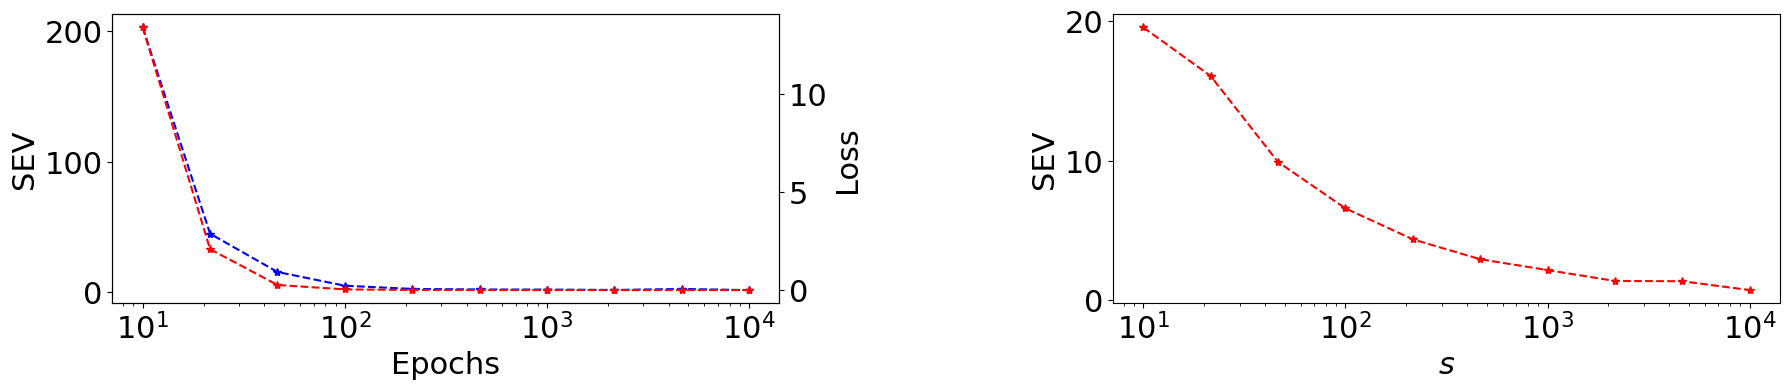

In [20]:
import matplotlib.pyplot as plt
w, h, fs = int(28/3 * 2), 4, 22
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(w,h),frameon=True,)

ax1t = ax1.twinx()

ax1.plot(epochs,diff_e_av,'b--*',label='Variance Squared Error')
ax1.set_ylabel('SEV', fontsize=fs)
# ax1.set_yscale('log')
ax1.set_xlabel('Epochs', fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1t.plot(epochs,losses_e_av,'r--*',label='Training Loss')
ax1t.spines['right'].set_visible(True)
ax1t.spines['top'].set_visible(True)
ax1t.set_ylabel('Loss', fontsize=fs)
# ax2.set_yscale('log')
ax1t.set_xscale('log')
ax1t.tick_params(labelsize=fs)

# ax1.legend(loc='best', fontsize=fs)
# ax1t.legend(loc='upper left', fontsize=fs)

ax2.plot(s_range,diff_s_av,'r--*')
ax2.set_ylabel('SEV', fontsize=fs)
# ax1.set_yscale('log')
ax2.set_xlabel('$s$', fontsize=fs)
ax2.set_xscale('log')
ax2.tick_params(labelsize=fs)

fig.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.savefig(fname='epochs_ntk_convergence.pdf', format='pdf')

# Multiple Plot

In [28]:
import torch
from functorch import make_functional
from torch.func import functional_call, vmap, jacrev, jvp
    ## NUQLS
import posteriors.nuqls as nuqls
from importlib import reload
reload(nuqls)
from torch.utils.data import DataLoader, Dataset
import tqdm

class toy_dataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
class variable_mlp(torch.nn.Module):
    def __init__(self,layer_width,nonlin):
        super().__init__()
        self.layer_width = layer_width
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_width[i],layer_width[i+1], bias=False) for i in range(len(self.layer_width)-1)])
        self.lin_out = torch.nn.Linear(self.layer_width[-1],1, bias=False)
        if nonlin=='tanh':
            self.act = torch.nn.Tanh()
        elif nonlin=='relu':
            self.act = torch.nn.ReLU()

        for lin in self.linear_layers:
            torch.nn.init.normal_(lin.weight, 0, 1)
        torch.nn.init.normal_(self.lin_out.weight, 0, 1)

    # Return full output of nn
    def forward(self,x):
        for i, lin in enumerate(self.linear_layers):
            x = self.act(lin(x)) / (self.layer_width[i]**0.5)
        return self.lin_out(x)
    
# class oneLayerMLP(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.output_size = 1
#         self.linear1 = torch.nn.Linear(d,dl,bias=False)
#         self.linear2 = torch.nn.Linear(dl,dl,bias=False)
#         self.linear3 = torch.nn.Linear(dl,1,bias=False)
#         self.act = torch.nn.ReLU()

#     def forward(self, x):
#         x = self.act(self.linear1(x)) /  (dl**0.5)
#         x = self.act(self.linear2(x)) /  (dl**0.5)
#         x = self.linear3(x)
#         return x

# def weights_init(m):
#     if isinstance(m, torch.nn.Linear):
#         # torch.nn.init.kaiming_normal(m.weight, mode='fan_out', nonlinearity='relu')
#             torch.nn.init.normal_(m.weight,mean=0,std=1)

def convergence(n,d,layer_widths,nonlin,lr=1,verbose=False):
    X = torch.randn((n,d))
    Y = torch.randn((n,1))

    X_test = torch.randn((n,d))

    net = variable_mlp(layer_width=layer_widths,nonlin=nonlin)

    optimizer = torch.optim.SGD(net.parameters(),lr=0.1,momentum=0.9)
    loss_fn = torch.nn.MSELoss()
    for i in range(5000):
        optimizer.zero_grad()
        pred = net(X)
        loss = loss_fn(pred,Y)
        loss.backward()
        optimizer.step()

    if verbose:
        print(f'nn loss : {loss.item():.4}')

    # Compute NTKGP
    fnet, params = make_functional(net)

    ## Compute jacobian of net, evaluated on training set
    def fnet_single(params, x):
        return fnet(params, x.unsqueeze(0)).squeeze(0)

    def Jx(Xs):
        J = vmap(jacrev(fnet_single), (None, 0))(params, Xs)
        J = [j.detach().flatten(1) for j in J]
        J = torch.cat(J,dim=1).detach()
        return J

    lam = 0
    Jtrain = Jx(X)
    NTK_X = Jtrain @ Jtrain.T + lam*torch.eye(n)
    cond = torch.linalg.cond(NTK_X).item()
    print(f'Cond(J J^T) = {cond:.1}')

    var_ntk = []
    for xi in X_test:
        Jsingle = Jx(xi.unsqueeze(0))
        KXx = Jtrain @ Jsingle.T
        var = Jsingle @ Jsingle.T - KXx.T @ torch.linalg.solve(NTK_X,KXx)
        var_ntk.append(var)
    var_ntk = torch.tensor(var_ntk)
    
    train_data = toy_dataset(X,Y)
    test_data = toy_dataset(X_test,Y)

    diff_e = []
    losses_e = []

    epochs = torch.logspace(1,4,10)
    for epoch in tqdm.tqdm(epochs):
        # nuql_test_preds, loss = nuqls.regression_parallel(net, train=train_data, test=test_data, ood_test=None, train_bs = n, test_bs =n, 
        #                                             S = 1000, scale=1, lr=8, epochs=int(epoch.item()), mu=0.9)
        
        nuql = nuqls.small_regression_parallel(net, train=train_data, S = 1000, epochs=int(epoch.item()), lr=lr, bs=n, bs_test=n, init_scale=1)
        loss,_ = nuql.train_linear(mu=0.9,weight_decay=0,my=0,sy=1,threshold=None,verbose=False, progress_bar=False)
        nuql_test_preds = nuql.test_linear(test=test_data)
        
        var_nuqls = nuql_test_preds.var(1)

        # print(f'epoch: {epoch}, convergence = {torch.linalg.norm(var_nuqls - var_ntk)}')
        diff_e.append(torch.linalg.norm(var_nuqls - var_ntk).item())
        losses_e.append(loss)
        if verbose:
            print('--------------------------------------')
            print(f'epoch: {int(epoch)}, nuqls loss : {loss.item():.4}')

    diff_s = []
    losses_s = []

    s_range = torch.logspace(1,4,10)
    for s in tqdm.tqdm(s_range):
        # nuql_test_preds, loss = nuqls.regression_parallel(net, train=train_data, test=test_data, ood_test=None, train_bs = n, test_bs =n, 
        #                                             S = int(s.item()), scale=1, lr=8, epochs=4000, mu=0.9)
        
        nuql = nuqls.small_regression_parallel(net, train=train_data, S = int(s.item()), epochs=4000, lr=lr, bs=n, bs_test=n, init_scale=1)
        loss,_ = nuql.train_linear(mu=0.9,weight_decay=0,my=0,sy=1,threshold=None,verbose=False, progress_bar=False)
        nuql_test_preds = nuql.test_linear(test=test_data)
        
        var_nuqls = nuql_test_preds.var(1)

        # print(f's: {s}, convergence = {torch.linalg.norm(var_nuqls - var_ntk)}')
        diff_s.append(torch.linalg.norm(var_nuqls - var_ntk).item())
        losses_s.append(loss)
        if verbose:
            print('--------------------------------------')
            print(f'S: {int(s)}, nuqls loss : {loss.item():.4}')

    return diff_e,losses_e,epochs,diff_s,losses_s,s_range,cond


In [60]:
samples = 2
n = 100
d = 5
results_dict = {}

# single-layer, width=20, tanh
print(f'single-layer, width=20, tanh')
layer_widths = [d,20]

diff_e_av = []
losses_e_av = []
diff_s_av = []
conds = []

for i in range(samples):
    diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='tanh',lr=0.1,verbose=True)
    diff_e_av.append(diff_e)
    losses_e_av.append(losses_e)
    diff_s_av.append(diff_s)
    conds.append(cond_i)

epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
cond_avg = torch.tensor(conds).mean(0)
results_dict['tanh_single_20'] = {'epoch_sev_avg': epoch_sev_avg,
                                  'epoch_sev_var': epoch_sev_var,
                                  'epoch_loss_avg': epoch_loss_avg,
                                  'epoch_loss_var': epoch_loss_var,
                                  's_sev_avg': s_sev_avg,
                                  's_sev_var': s_sev_var,
                                  'cond_avg': cond_avg,
                                  'epoch_range': epochs,
                                  's_range': s_range}
torch.save(results_dict,'convergence_result_dict.pt')

# single-layer, width=20, relu
print(f'single-layer, width=20, relu')
layer_widths = [d,20]

diff_e_av = []
losses_e_av = []
diff_s_av = []
conds = []

for i in range(samples):
    diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='relu',lr=0.1,verbose=True)
    diff_e_av.append(diff_e)
    losses_e_av.append(losses_e)
    diff_s_av.append(diff_s)
    conds.append(cond_i)

epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
cond_avg = torch.tensor(conds).mean(0)
results_dict['relu_single_20'] = {'epoch_sev_avg': epoch_sev_avg,
                                  'epoch_sev_var': epoch_sev_var,
                                  'epoch_loss_avg': epoch_loss_avg,
                                  'epoch_loss_var': epoch_loss_var,
                                  's_sev_avg': s_sev_avg,
                                  's_sev_var': s_sev_var,
                                  'cond_avg': cond_avg,
                                  'epoch_range': epochs,
                                  's_range': s_range}
torch.save(results_dict,'convergence_result_dict.pt')

# double-layer, width=20, relu
print(f'double-layer, width=20, relu')
layer_widths = [d,20,20]

diff_e_av = []
losses_e_av = []
diff_s_av = []
conds = []

for i in range(samples):
    diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='relu',lr=0.1,verbose=True)
    diff_e_av.append(diff_e)
    losses_e_av.append(losses_e)
    diff_s_av.append(diff_s)
    conds.append(cond_i)

epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
cond_avg = torch.tensor(conds).mean(0)
results_dict['relu_double_20'] = {'epoch_sev_avg': epoch_sev_avg,
                                  'epoch_sev_var': epoch_sev_var,
                                  'epoch_loss_avg': epoch_loss_avg,
                                  'epoch_loss_var': epoch_loss_var,
                                  's_sev_avg': s_sev_avg,
                                  's_sev_var': s_sev_var,
                                  'cond_avg': cond_avg,
                                  'epoch_range': epochs,
                                  's_range': s_range}
torch.save(results_dict,'convergence_result_dict.pt')

# single-layer, width=100, tanh
print(f'single-layer, width=100, tanh')
layer_widths = [d,100]

diff_e_av = []
losses_e_av = []
diff_s_av = []
conds = []

for i in range(samples):
    diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='tanh',lr=0.1,verbose=True)
    diff_e_av.append(diff_e)
    losses_e_av.append(losses_e)
    diff_s_av.append(diff_s)
    conds.append(cond_i)

epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
cond_avg = torch.tensor(conds).mean(0)
results_dict['tanh_single_100'] = {'epoch_sev_avg': epoch_sev_avg,
                                  'epoch_sev_var': epoch_sev_var,
                                  'epoch_loss_avg': epoch_loss_avg,
                                  'epoch_loss_var': epoch_loss_var,
                                  's_sev_avg': s_sev_avg,
                                  's_sev_var': s_sev_var,
                                  'cond_avg': cond_avg,
                                  'epoch_range': epochs,
                                  's_range': s_range}
torch.save(results_dict,'convergence_result_dict.pt')



single-layer, width=20, tanh


C:\Users\s4531973\AppData\Local\Temp\ipykernel_9080\475677823.py:84: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(net)


nn loss : 0.002964
Cond(J J^T) = 9e+04


  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\s4531973\Documents\PhD\Code\nuqls_paper\posteriors\nuqls.py:156: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  self.fnet, self.params = make_functional(self.net)
 30%|███       | 3/10 [00:00<00:00, 23.14it/s]

--------------------------------------
epoch: 10, nuqls loss : 5.727
--------------------------------------
epoch: 21, nuqls loss : 1.568
--------------------------------------
epoch: 46, nuqls loss : 0.1976
--------------------------------------
epoch: 100, nuqls loss : 0.04516
--------------------------------------
epoch: 215, nuqls loss : 0.019


 60%|██████    | 6/10 [00:01<00:00,  4.52it/s]

--------------------------------------
epoch: 464, nuqls loss : 0.008873
--------------------------------------
epoch: 1000, nuqls loss : 0.004923


 80%|████████  | 8/10 [00:05<00:01,  1.05it/s]

--------------------------------------
epoch: 2154, nuqls loss : 0.003278


 90%|█████████ | 9/10 [00:12<00:02,  2.07s/it]

--------------------------------------
epoch: 4641, nuqls loss : 0.00222


100%|██████████| 10/10 [00:38<00:00,  3.87s/it]


--------------------------------------
epoch: 10000, nuqls loss : 0.001264


 10%|█         | 1/10 [00:03<00:31,  3.46s/it]

--------------------------------------
S: 10, nuqls loss : 0.00247


 20%|██        | 2/10 [00:07<00:28,  3.54s/it]

--------------------------------------
S: 21, nuqls loss : 0.002448


 30%|███       | 3/10 [00:10<00:24,  3.50s/it]

--------------------------------------
S: 46, nuqls loss : 0.002189


 40%|████      | 4/10 [00:14<00:21,  3.57s/it]

--------------------------------------
S: 100, nuqls loss : 0.002396


 50%|█████     | 5/10 [00:18<00:19,  3.99s/it]

--------------------------------------
S: 215, nuqls loss : 0.002337


 60%|██████    | 6/10 [00:27<00:22,  5.71s/it]

--------------------------------------
S: 464, nuqls loss : 0.002373


 70%|███████   | 7/10 [00:40<00:24,  8.02s/it]

--------------------------------------
S: 1000, nuqls loss : 0.002367


 80%|████████  | 8/10 [01:02<00:25, 12.51s/it]

--------------------------------------
S: 2154, nuqls loss : 0.002362


 90%|█████████ | 9/10 [01:44<00:21, 21.49s/it]

--------------------------------------
S: 4641, nuqls loss : 0.00238


100%|██████████| 10/10 [03:14<00:00, 19.45s/it]

--------------------------------------
S: 10000, nuqls loss : 0.002376


nn loss : 7.474e-05
Cond(J J^T) = 4e+04


 20%|██        | 2/10 [00:00<00:00, 14.96it/s]

--------------------------------------
epoch: 10, nuqls loss : 6.661
--------------------------------------
epoch: 21, nuqls loss : 1.42
--------------------------------------
epoch: 46, nuqls loss : 0.2015


 40%|████      | 4/10 [00:00<00:01,  4.76it/s]

--------------------------------------
epoch: 100, nuqls loss : 0.03917


 50%|█████     | 5/10 [00:01<00:01,  2.60it/s]

--------------------------------------
epoch: 215, nuqls loss : 0.01465


 60%|██████    | 6/10 [00:03<00:02,  1.40it/s]

--------------------------------------
epoch: 464, nuqls loss : 0.005575


 70%|███████   | 7/10 [00:06<00:04,  1.49s/it]

--------------------------------------
epoch: 1000, nuqls loss : 0.001844


 80%|████████  | 8/10 [00:13<00:06,  3.12s/it]

--------------------------------------
epoch: 2154, nuqls loss : 0.0005507


 90%|█████████ | 9/10 [00:28<00:06,  6.65s/it]

--------------------------------------
epoch: 4641, nuqls loss : 0.0001459


100%|██████████| 10/10 [01:00<00:00,  6.00s/it]


--------------------------------------
epoch: 10000, nuqls loss : 2.595e-05


 10%|█         | 1/10 [00:03<00:32,  3.64s/it]

--------------------------------------
S: 10, nuqls loss : 0.0002948


 20%|██        | 2/10 [00:07<00:31,  3.96s/it]

--------------------------------------
S: 21, nuqls loss : 0.0002423


 30%|███       | 3/10 [00:11<00:25,  3.65s/it]

--------------------------------------
S: 46, nuqls loss : 0.00021


 40%|████      | 4/10 [00:14<00:21,  3.58s/it]

--------------------------------------
S: 100, nuqls loss : 0.0001794


 50%|█████     | 5/10 [00:19<00:20,  4.01s/it]

--------------------------------------
S: 215, nuqls loss : 0.0001931


 60%|██████    | 6/10 [00:28<00:22,  5.65s/it]

--------------------------------------
S: 464, nuqls loss : 0.0001931


 70%|███████   | 7/10 [00:34<00:17,  5.90s/it]

--------------------------------------
S: 1000, nuqls loss : 0.0001893


 80%|████████  | 8/10 [00:43<00:13,  6.79s/it]

--------------------------------------
S: 2154, nuqls loss : 0.0001956


 90%|█████████ | 9/10 [00:59<00:09,  9.87s/it]

--------------------------------------
S: 4641, nuqls loss : 0.00019


100%|██████████| 10/10 [01:35<00:00,  9.52s/it]

--------------------------------------
S: 10000, nuqls loss : 0.0001915
single-layer, width=20, relu


nn loss : 0.114
Cond(J J^T) = 3e+07


  0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------------
epoch: 10, nuqls loss : 24.91
--------------------------------------
epoch: 21, nuqls loss : 9.018
--------------------------------------
epoch: 46, nuqls loss : 0.606


 30%|███       | 3/10 [00:00<00:00, 22.48it/s]

--------------------------------------
epoch: 100, nuqls loss : 0.04782
--------------------------------------
epoch: 215, nuqls loss : 0.02349


 60%|██████    | 6/10 [00:01<00:00,  4.27it/s]

--------------------------------------
epoch: 464, nuqls loss : 0.01427
--------------------------------------
epoch: 1000, nuqls loss : 0.01036


 80%|████████  | 8/10 [00:05<00:01,  1.06it/s]

--------------------------------------
epoch: 2154, nuqls loss : 0.007589


 90%|█████████ | 9/10 [00:12<00:02,  2.09s/it]

--------------------------------------
epoch: 4641, nuqls loss : 0.005055


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


--------------------------------------
epoch: 10000, nuqls loss : 0.002754


 10%|█         | 1/10 [00:01<00:11,  1.23s/it]

--------------------------------------
S: 10, nuqls loss : 0.005438


 20%|██        | 2/10 [00:02<00:09,  1.22s/it]

--------------------------------------
S: 21, nuqls loss : 0.005558


 30%|███       | 3/10 [00:03<00:08,  1.27s/it]

--------------------------------------
S: 46, nuqls loss : 0.005558


 40%|████      | 4/10 [00:05<00:08,  1.38s/it]

--------------------------------------
S: 100, nuqls loss : 0.005654


 50%|█████     | 5/10 [00:07<00:07,  1.58s/it]

--------------------------------------
S: 215, nuqls loss : 0.005514


 60%|██████    | 6/10 [00:11<00:10,  2.60s/it]

--------------------------------------
S: 464, nuqls loss : 0.005587


 70%|███████   | 7/10 [00:17<00:10,  3.57s/it]

--------------------------------------
S: 1000, nuqls loss : 0.005563


 80%|████████  | 8/10 [00:26<00:10,  5.23s/it]

--------------------------------------
S: 2154, nuqls loss : 0.005553


 90%|█████████ | 9/10 [00:42<00:08,  8.84s/it]

--------------------------------------
S: 4641, nuqls loss : 0.005531


100%|██████████| 10/10 [01:19<00:00,  7.97s/it]

--------------------------------------
S: 10000, nuqls loss : 0.005541


nn loss : 0.04079
Cond(J J^T) = 2e+07


  0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------------
epoch: 10, nuqls loss : 37.05
--------------------------------------
epoch: 21, nuqls loss : 8.533
--------------------------------------
epoch: 46, nuqls loss : 0.9382


 30%|███       | 3/10 [00:00<00:00, 25.80it/s]

--------------------------------------
epoch: 100, nuqls loss : 0.06397
--------------------------------------
epoch: 215, nuqls loss : 0.03996


 60%|██████    | 6/10 [00:01<00:00,  4.44it/s]

--------------------------------------
epoch: 464, nuqls loss : 0.03079
--------------------------------------
epoch: 1000, nuqls loss : 0.0254


 80%|████████  | 8/10 [00:05<00:01,  1.04it/s]

--------------------------------------
epoch: 2154, nuqls loss : 0.02102


 90%|█████████ | 9/10 [00:12<00:02,  2.18s/it]

--------------------------------------
epoch: 4641, nuqls loss : 0.01696


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


--------------------------------------
epoch: 10000, nuqls loss : 0.01247


 10%|█         | 1/10 [00:01<00:11,  1.28s/it]

--------------------------------------
S: 10, nuqls loss : 0.01761


 20%|██        | 2/10 [00:02<00:10,  1.26s/it]

--------------------------------------
S: 21, nuqls loss : 0.01776


 30%|███       | 3/10 [00:03<00:09,  1.30s/it]

--------------------------------------
S: 46, nuqls loss : 0.01784


 40%|████      | 4/10 [00:05<00:08,  1.37s/it]

--------------------------------------
S: 100, nuqls loss : 0.01768


 50%|█████     | 5/10 [00:07<00:07,  1.59s/it]

--------------------------------------
S: 215, nuqls loss : 0.0178


 60%|██████    | 6/10 [00:12<00:10,  2.72s/it]

--------------------------------------
S: 464, nuqls loss : 0.01779


 70%|███████   | 7/10 [00:18<00:11,  3.96s/it]

--------------------------------------
S: 1000, nuqls loss : 0.01775


 80%|████████  | 8/10 [00:27<00:11,  5.63s/it]

--------------------------------------
S: 2154, nuqls loss : 0.01777


 90%|█████████ | 9/10 [00:45<00:09,  9.36s/it]

--------------------------------------
S: 4641, nuqls loss : 0.01773


100%|██████████| 10/10 [01:24<00:00,  8.40s/it]

--------------------------------------
S: 10000, nuqls loss : 0.01773
double-layer, width=20, relu


nn loss : 5.138e-12
Cond(J J^T) = 8e+03


  0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------------
epoch: 10, nuqls loss : 24.82


 20%|██        | 2/10 [00:00<00:00, 14.96it/s]

--------------------------------------
epoch: 21, nuqls loss : 5.421
--------------------------------------
epoch: 46, nuqls loss : 0.5893


 40%|████      | 4/10 [00:00<00:01,  5.72it/s]

--------------------------------------
epoch: 100, nuqls loss : 0.01656


 50%|█████     | 5/10 [00:01<00:01,  2.94it/s]

--------------------------------------
epoch: 215, nuqls loss : 0.002688


 60%|██████    | 6/10 [00:02<00:02,  1.38it/s]

--------------------------------------
epoch: 464, nuqls loss : 0.0003497


 70%|███████   | 7/10 [00:06<00:04,  1.59s/it]

--------------------------------------
epoch: 1000, nuqls loss : 2.209e-05


 80%|████████  | 8/10 [00:14<00:06,  3.47s/it]

--------------------------------------
epoch: 2154, nuqls loss : 9.614e-08


 90%|█████████ | 9/10 [00:31<00:07,  7.50s/it]

--------------------------------------
epoch: 4641, nuqls loss : 8.432e-13


100%|██████████| 10/10 [01:08<00:00,  6.80s/it]


--------------------------------------
epoch: 10000, nuqls loss : 1.003e-23


 10%|█         | 1/10 [00:01<00:13,  1.47s/it]

--------------------------------------
S: 10, nuqls loss : 1.265e-11


 20%|██        | 2/10 [00:03<00:12,  1.54s/it]

--------------------------------------
S: 21, nuqls loss : 1.722e-11


 30%|███       | 3/10 [00:04<00:11,  1.69s/it]

--------------------------------------
S: 46, nuqls loss : 2.107e-11


 40%|████      | 4/10 [00:08<00:14,  2.42s/it]

--------------------------------------
S: 100, nuqls loss : 1.608e-11


 50%|█████     | 5/10 [00:12<00:15,  3.15s/it]

--------------------------------------
S: 215, nuqls loss : 1.999e-11


 60%|██████    | 6/10 [00:20<00:18,  4.66s/it]

--------------------------------------
S: 464, nuqls loss : 1.736e-11


 70%|███████   | 7/10 [00:34<00:23,  7.82s/it]

--------------------------------------
S: 1000, nuqls loss : 1.713e-11


 80%|████████  | 8/10 [01:03<00:29, 14.50s/it]

--------------------------------------
S: 2154, nuqls loss : 1.692e-11


 90%|█████████ | 9/10 [02:16<00:32, 32.65s/it]

--------------------------------------
S: 4641, nuqls loss : 1.681e-11


100%|██████████| 10/10 [06:23<00:00, 38.35s/it]

--------------------------------------
S: 10000, nuqls loss : 1.661e-11


nn loss : 8.587e-06
Cond(J J^T) = 2e+04


 10%|█         | 1/10 [00:00<00:01,  8.42it/s]

--------------------------------------
epoch: 10, nuqls loss : 19.18
--------------------------------------
epoch: 21, nuqls loss : 4.899


 30%|███       | 3/10 [00:00<00:01,  3.50it/s]

--------------------------------------
epoch: 46, nuqls loss : 0.4939


 40%|████      | 4/10 [00:01<00:03,  1.97it/s]

--------------------------------------
epoch: 100, nuqls loss : 0.02218


 50%|█████     | 5/10 [00:03<00:04,  1.04it/s]

--------------------------------------
epoch: 215, nuqls loss : 0.004107


 60%|██████    | 6/10 [00:07<00:07,  1.92s/it]

--------------------------------------
epoch: 464, nuqls loss : 0.0008631


 70%|███████   | 7/10 [00:15<00:12,  4.05s/it]

--------------------------------------
epoch: 1000, nuqls loss : 0.0002001


 80%|████████  | 8/10 [00:33<00:16,  8.41s/it]

--------------------------------------
epoch: 2154, nuqls loss : 2.361e-05


 90%|█████████ | 9/10 [01:11<00:17, 17.75s/it]

--------------------------------------
epoch: 4641, nuqls loss : 3.415e-07


100%|██████████| 10/10 [02:33<00:00, 15.36s/it]


--------------------------------------
epoch: 10000, nuqls loss : 4.136e-11


 10%|█         | 1/10 [00:03<00:34,  3.78s/it]

--------------------------------------
S: 10, nuqls loss : 1.163e-06


 20%|██        | 2/10 [00:07<00:29,  3.74s/it]

--------------------------------------
S: 21, nuqls loss : 5.737e-07


 30%|███       | 3/10 [00:12<00:28,  4.14s/it]

--------------------------------------
S: 46, nuqls loss : 8.6e-07


 40%|████      | 4/10 [00:19<00:32,  5.46s/it]

--------------------------------------
S: 100, nuqls loss : 1.052e-06


 50%|█████     | 5/10 [00:30<00:37,  7.41s/it]

--------------------------------------
S: 215, nuqls loss : 1.057e-06


 60%|██████    | 6/10 [00:48<00:44, 11.03s/it]

--------------------------------------
S: 464, nuqls loss : 9.61e-07


 70%|███████   | 7/10 [01:21<00:54, 18.15s/it]

--------------------------------------
S: 1000, nuqls loss : 1.016e-06


 80%|████████  | 8/10 [02:31<01:09, 34.87s/it]

--------------------------------------
S: 2154, nuqls loss : 1.042e-06


 90%|█████████ | 9/10 [05:14<01:14, 74.85s/it]

--------------------------------------
S: 4641, nuqls loss : 1.012e-06


100%|██████████| 10/10 [10:53<00:00, 65.32s/it] 

--------------------------------------
S: 10000, nuqls loss : 9.918e-07
single-layer, width=100, tanh


nn loss : 5.165e-18
Cond(J J^T) = 3e+03


 10%|█         | 1/10 [00:00<00:01,  7.95it/s]

--------------------------------------
epoch: 10, nuqls loss : 4.693


 20%|██        | 2/10 [00:00<00:01,  5.27it/s]

--------------------------------------
epoch: 21, nuqls loss : 1.669


 30%|███       | 3/10 [00:00<00:02,  3.14it/s]

--------------------------------------
epoch: 46, nuqls loss : 0.2349


 40%|████      | 4/10 [00:01<00:03,  1.76it/s]

--------------------------------------
epoch: 100, nuqls loss : 0.03862


 50%|█████     | 5/10 [00:03<00:05,  1.09s/it]

--------------------------------------
epoch: 215, nuqls loss : 0.01034


 60%|██████    | 6/10 [00:08<00:08,  2.21s/it]

--------------------------------------
epoch: 464, nuqls loss : 0.002059


 70%|███████   | 7/10 [00:17<00:13,  4.47s/it]

--------------------------------------
epoch: 1000, nuqls loss : 0.0001698


 80%|████████  | 8/10 [00:37<00:18,  9.35s/it]

--------------------------------------
epoch: 2154, nuqls loss : 2.04e-06


 90%|█████████ | 9/10 [01:19<00:19, 19.62s/it]

--------------------------------------
epoch: 4641, nuqls loss : 3.101e-10


100%|██████████| 10/10 [02:52<00:00, 17.26s/it]


--------------------------------------
epoch: 10000, nuqls loss : 4.535e-18


 10%|█         | 1/10 [00:03<00:32,  3.66s/it]

--------------------------------------
S: 10, nuqls loss : 6.1e-09


 20%|██        | 2/10 [00:07<00:31,  3.90s/it]

--------------------------------------
S: 21, nuqls loss : 4.229e-09


 30%|███       | 3/10 [00:12<00:31,  4.45s/it]

--------------------------------------
S: 46, nuqls loss : 2.766e-09


 40%|████      | 4/10 [00:20<00:35,  5.87s/it]

--------------------------------------
S: 100, nuqls loss : 3.069e-09


 50%|█████     | 5/10 [00:32<00:39,  7.96s/it]

--------------------------------------
S: 215, nuqls loss : 2.833e-09


 60%|██████    | 6/10 [00:52<00:48, 12.18s/it]

--------------------------------------
S: 464, nuqls loss : 2.77e-09


 70%|███████   | 7/10 [01:29<01:00, 20.18s/it]

--------------------------------------
S: 1000, nuqls loss : 2.786e-09


 80%|████████  | 8/10 [02:52<01:20, 40.08s/it]

--------------------------------------
S: 2154, nuqls loss : 2.875e-09


 90%|█████████ | 9/10 [05:52<01:23, 83.75s/it]

--------------------------------------
S: 4641, nuqls loss : 2.964e-09


100%|██████████| 10/10 [10:31<00:00, 63.17s/it] 

--------------------------------------
S: 10000, nuqls loss : 2.913e-09


nn loss : 1.733e-18
Cond(J J^T) = 4e+03


 10%|█         | 1/10 [00:00<00:01,  7.30it/s]

--------------------------------------
epoch: 10, nuqls loss : 4.748


 20%|██        | 2/10 [00:00<00:01,  5.03it/s]

--------------------------------------
epoch: 21, nuqls loss : 2.074


 30%|███       | 3/10 [00:00<00:02,  3.05it/s]

--------------------------------------
epoch: 46, nuqls loss : 0.2451


 40%|████      | 4/10 [00:01<00:03,  1.69it/s]

--------------------------------------
epoch: 100, nuqls loss : 0.04029


 50%|█████     | 5/10 [00:03<00:05,  1.10s/it]

--------------------------------------
epoch: 215, nuqls loss : 0.009877


 60%|██████    | 6/10 [00:08<00:08,  2.22s/it]

--------------------------------------
epoch: 464, nuqls loss : 0.00178


 70%|███████   | 7/10 [00:17<00:13,  4.51s/it]

--------------------------------------
epoch: 1000, nuqls loss : 0.0001788


 80%|████████  | 8/10 [00:37<00:19,  9.59s/it]

--------------------------------------
epoch: 2154, nuqls loss : 4.441e-06


 90%|█████████ | 9/10 [01:20<00:19, 19.99s/it]

--------------------------------------
epoch: 4641, nuqls loss : 3.663e-09


100%|██████████| 10/10 [02:53<00:00, 17.34s/it]


--------------------------------------
epoch: 10000, nuqls loss : 1.314e-15


 10%|█         | 1/10 [00:03<00:32,  3.62s/it]

--------------------------------------
S: 10, nuqls loss : 3.459e-08


 20%|██        | 2/10 [00:07<00:30,  3.86s/it]

--------------------------------------
S: 21, nuqls loss : 2.309e-08


 30%|███       | 3/10 [00:12<00:31,  4.43s/it]

--------------------------------------
S: 46, nuqls loss : 1.932e-08


 40%|████      | 4/10 [00:20<00:35,  5.87s/it]

--------------------------------------
S: 100, nuqls loss : 2.158e-08


 50%|█████     | 5/10 [00:32<00:40,  8.09s/it]

--------------------------------------
S: 215, nuqls loss : 2.513e-08


 60%|██████    | 6/10 [00:53<00:48, 12.25s/it]

--------------------------------------
S: 464, nuqls loss : 2.324e-08


 70%|███████   | 7/10 [01:30<01:01, 20.37s/it]

--------------------------------------
S: 1000, nuqls loss : 2.184e-08


 80%|████████  | 8/10 [02:53<01:21, 40.52s/it]

--------------------------------------
S: 2154, nuqls loss : 2.227e-08


 90%|█████████ | 9/10 [05:39<01:19, 79.47s/it]

--------------------------------------
S: 4641, nuqls loss : 2.204e-08


100%|██████████| 10/10 [12:09<00:00, 72.94s/it] 

--------------------------------------
S: 10000, nuqls loss : 2.196e-08


C:\Users\s4531973\AppData\Local\Temp\ipykernel_1468\2772647244.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results_dict = torch.load('convergence_result_dict.pt')


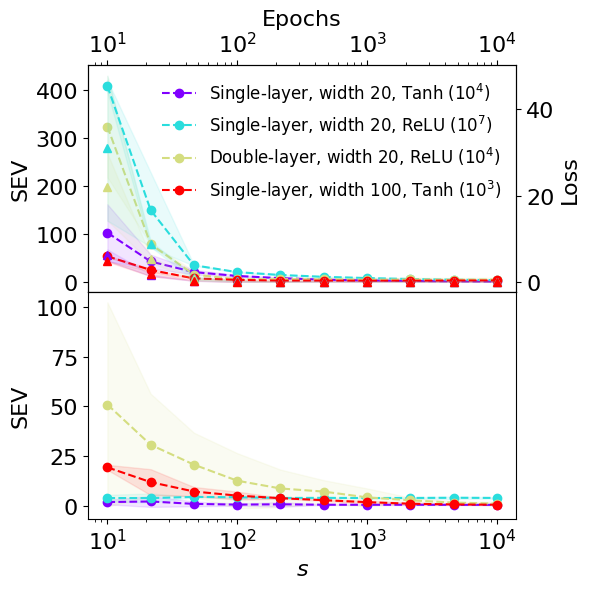

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import cm
import torch

results_dict = torch.load('convergence_result_dict.pt')

label_dict = {'tanh_single_20': 'Single-layer, width 20, Tanh',
              'relu_single_20': 'Single-layer, width 20, ReLU',
              'relu_double_20': 'Double-layer, width 20, ReLU',
              'tanh_single_100': 'Single-layer, width 100, Tanh'}

w, h, fs = 6, 6, 16
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(w,h),frameon=True,)
color = cm.rainbow(np.linspace(0, 1, 4))

ax1t = ax1.twinx()
ax1.set_ylabel('SEV', fontsize=fs)
ax1.set_xlabel('Epochs', fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1t.spines['right'].set_visible(True)
ax1t.spines['top'].set_visible(True)
ax1t.set_ylabel('Loss', fontsize=fs)
ax1t.set_xscale('log')
ax1t.tick_params(labelsize=fs)
ax2.set_ylabel('SEV', fontsize=fs)
ax2.set_xlabel('$s$', fontsize=fs)
ax2.set_xscale('log')
ax2.tick_params(labelsize=fs)

for i,key in enumerate(results_dict.keys()):
    exponent = int(floor(log10(abs(results_dict[key]['cond_avg']))))
    ax1.plot(results_dict[key]['epoch_range'],
             results_dict[key]['epoch_sev_avg'],
             color=color[i],marker='o',linestyle='dashed',
             label=label_dict[key] + f" ($10^{exponent}$)"
    )
    ax1.fill_between(results_dict[key]['epoch_range'],
             results_dict[key]['epoch_sev_avg'] - 1.96 * np.sqrt(results_dict[key]['epoch_sev_var']),
             results_dict[key]['epoch_sev_avg'] + 1.96 * np.sqrt(results_dict[key]['epoch_sev_var']),
             color=color[i],alpha=0.1)
    
    ax1t.plot(results_dict[key]['epoch_range'],
              results_dict[key]['epoch_loss_avg'],
              color=color[i],marker='^',linestyle='none')
    ax1t.fill_between(results_dict[key]['epoch_range'],
             results_dict[key]['epoch_loss_avg'] - 1.96 * np.sqrt(results_dict[key]['epoch_loss_var']),
             results_dict[key]['epoch_loss_avg'] + 1.96 * np.sqrt(results_dict[key]['epoch_loss_var']),
             color=color[i],alpha=0.1)
    
    ax2.plot(results_dict[key]['s_range'],
             results_dict[key]['s_sev_avg'],color=color[i],marker='o',linestyle='dashed',)
    ax2.fill_between(results_dict[key]['epoch_range'],
             results_dict[key]['s_sev_avg'] - 1.96 * np.sqrt(results_dict[key]['s_sev_var']),
             results_dict[key]['s_sev_avg'] + 1.96 * np.sqrt(results_dict[key]['s_sev_var']),
             color=color[i],alpha=0.1)

ax1.legend(fontsize=int(fs * 0.75), frameon=False)
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(fname='epochs_ntk_convergence.pdf', format='pdf')